### The goal of this program is to perform a baseline analysis for a standard unified loan prediction dataset using a simple ANN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time #check min_threshold values for cloud storage
from sklearn.model_selection import train_test_split #don't use for time-series baseline!
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
train_df = pd.read_csv("../../data/archive/train.csv")
test_df = pd.read_csv("../../data/archive/test.csv")

In [3]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
test_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


## Data pre-processing

In [5]:
def preprocess_df(dataframe, isTest=False):
    """Preprocess a dataframe, unique to the loan_prediction dataset"""
    #perform deep copy, fixes self assignment bug:
    #https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
    df = dataframe.copy(deep=True)
    
    null_df = np.sum(df.isnull())
    print(null_df) 
    print(f"\nTotal null values: {np.sum(null_df)}") #get total number of null values
    ### remove all rows with null values
    df = df.dropna(how='any',axis=0) 
    del df['Loan_ID'] #remove Loan_ID (irrelevant)

    # convert to binary variables

    ##----------------------------------------------------------------------------
    #### ----------------------------------Table----------------------------------
    ##----------------------------------------------------------------------------

    #> ----Gender---
    ## - Male: 0
    ## - Female: 1
    df.loc[(df.Gender == 'Male'),'Gender']=0
    df.loc[(df.Gender == 'Female'),'Gender']=1

    #> ----Married---
    ## - No: 0
    ## - Yes: 1
    df.loc[(df.Married == 'Yes'),'Married']=0
    df.loc[(df.Married == 'No'),'Married']=1

    #> ----Education---
    ## - Not Graduate: 0
    ## - Graduate: 1
    df.loc[(df.Education == 'Not Graduate'),'Education']=0
    df.loc[(df.Education == 'Graduate'),'Education']=1

    #> ----Self_Employed---
    ## - No: 0
    ## - Yes: 1
    df.loc[(df.Self_Employed == 'No'),'Self_Employed']=0
    df.loc[(df.Self_Employed == 'Yes'),'Self_Employed']=1


    #> ----Property_area---
    ## - Rural: 0
    ## - Urban: 1
    ## - Semiurban: 2
    df.loc[(df.Property_Area == 'Rural'),'Property_Area']=0
    df.loc[(df.Property_Area == 'Urban'),'Property_Area']=1
    df.loc[(df.Property_Area == 'Semiurban'),'Property_Area']=2
    
    
    #> ----Loan_Status--- (ONLY for Training set)
    ## - No: 0
    ## - Yes: 1
    if(not isTest):
        df.loc[(df.Loan_Status == 'N'),'Loan_Status']=0
        df.loc[(df.Loan_Status == 'Y'),'Loan_Status']=1

    #> -----Dependents-----
    #set max as 
    df.loc[(df.Dependents == '3+'), 'Dependents'] = 3
    ##----------------------------------------------------------------------------
    #### ----------------------------------Table----------------------------------
    ##----------------------------------------------------------------------------

    #!!! Typecase to float (for tensors below)
    df = df.astype(float)
    
    return df

In [6]:
train_df = preprocess_df(train_df)
test_df = preprocess_df(test_df, isTest=True)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Total null values: 149
Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

Total null values: 84


In [7]:
train_df.head() #processed

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,0.0,0.0,1.0,1.0,0.0,4583.0,1508.0,128.0,360.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,3000.0,0.0,66.0,360.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,2583.0,2358.0,120.0,360.0,1.0,1.0,1.0
4,0.0,1.0,0.0,1.0,0.0,6000.0,0.0,141.0,360.0,1.0,1.0,1.0
5,0.0,0.0,2.0,1.0,1.0,5417.0,4196.0,267.0,360.0,1.0,1.0,1.0


In [8]:
test_df.head() #processed

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,0.0,0.0,0.0,1.0,0.0,5720.0,0.0,110.0,360.0,1.0,1.0
1,0.0,0.0,1.0,1.0,0.0,3076.0,1500.0,126.0,360.0,1.0,1.0
2,0.0,0.0,2.0,1.0,0.0,5000.0,1800.0,208.0,360.0,1.0,1.0
4,0.0,1.0,0.0,0.0,0.0,3276.0,0.0,78.0,360.0,1.0,1.0
5,0.0,0.0,0.0,0.0,1.0,2165.0,3422.0,152.0,360.0,1.0,1.0


In [9]:
# split into training and testing
X_train = train_df.drop('Loan_Status',axis=1).values
y_train = train_df['Loan_Status'].values

X_test = test_df.values

In [10]:
print(f"Training data feature space: {X_train.shape}")
print(f"Testing data feature space: {X_test.shape}")

Training data feature space: (480, 11)
Testing data feature space: (289, 11)


In [11]:
### Create tensors from np.ndarry main data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Enable cuda if available

X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
# y_test = torch.LongTensor(y_test).to(device)

## Building Model

In [12]:
#main model for loan prediction (try out different values for hidden layers to improve baseline)
class NN(nn.Module):
    def __init__(self, input_features=11, layer1=20, layer2=20, out_features=2):
        """Initialize the model for loan prediction"""
        super().__init__()
        self.fc1 = nn.Linear(input_features, layer1)
        self.fc2 = nn.Linear(layer1, layer2)
        self.out = nn.Linear(layer2, out_features)
        
    def forward(self, x):
        """Forward pass with 11 input features"""
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [13]:
# seed the model for reproducibility (ideally across all nodes, later...)
torch.manual_seed(0)
model = NN()

In [14]:
model ##describe model, sort of (integrate tensorboard into PyTorch, not now tho)

NN(
  (fc1): Linear(in_features=11, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (out): Linear(in_features=20, out_features=2, bias=True)
)

In [15]:
model = model.to(device)

In [16]:
#model -- this is what we'll be working with.
print(model.state_dict())

OrderedDict([('fc1.weight', tensor([[-0.0023,  0.1617, -0.2482, -0.2219, -0.1161,  0.0809, -0.0060,  0.2391,
         -0.0268,  0.0798, -0.0911],
        [-0.0593, -0.2880, -0.1997, -0.1243,  0.0112,  0.1192,  0.1809, -0.2044,
         -0.1313,  0.1095,  0.2504],
        [-0.0621,  0.2256, -0.0486,  0.0319,  0.2730, -0.2797, -0.1898, -0.0763,
         -0.1175,  0.2605, -0.1954],
        [-0.1388, -0.2106, -0.2824, -0.1760,  0.2592,  0.1345,  0.1461,  0.0159,
         -0.1546,  0.0510, -0.2815],
        [-0.2179, -0.1554,  0.1902,  0.1768, -0.1337, -0.0109,  0.1928,  0.2997,
          0.1197,  0.0407,  0.2022],
        [-0.1775,  0.0562, -0.2338, -0.2090, -0.1558,  0.1364,  0.1213, -0.1786,
          0.0911,  0.1655, -0.0381],
        [ 0.0115,  0.0699,  0.1871,  0.2895, -0.2324, -0.1105,  0.1185,  0.2498,
          0.2624,  0.2660,  0.0600],
        [-0.2622,  0.0277, -0.1886, -0.2810,  0.2679,  0.2293, -0.3008,  0.0564,
         -0.0508, -0.0496, -0.1380],
        [ 0.1159, -0.1786,  

In [17]:
# implement backprop
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005) #adam works well for this.

In [18]:
def train(epochs=int(1e3), print_every=100, epsilon=0.5):
    """
    Train the model.
    - assumes access to following global variables: X_train, y_train, y_pred, model, loss function, & optimizer.
    @Param:
    1. epochs - number of training iterations.
    2. print_every - for visual purposes (set to None to ignore), outputs loss
    3. epsilon - threshold to break training.
    """
    start_time = time.time() #set start time
    losses = [] #plot
    
    for i in range(1, epochs+1):
        y_pred = model(X_train)
        loss = loss_function(y_pred, y_train)
        losses.append(loss)
        
        if(loss.item() <= epsilon):
            print(f"\nCONVERGED at epoch {i} - loss : {loss.item()}")
            break #converged
        
        if(print_every is not None and i%print_every == 1):
            print(f"Epoch {i} - loss : {loss.item()}")
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("total training time (sec):", time.time()-start_time)
    return losses

In [19]:
cost = train(epochs=int(1e5), epsilon=0.2) #hopefully, it didn't overfit. :D

Epoch 1 - loss : 64.05158996582031
Epoch 101 - loss : 1.4300655126571655
Epoch 201 - loss : 0.8461807370185852
Epoch 301 - loss : 0.7108176946640015
Epoch 401 - loss : 1.0031205415725708
Epoch 501 - loss : 0.696667492389679
Epoch 601 - loss : 0.5755214691162109
Epoch 701 - loss : 0.6424532532691956
Epoch 801 - loss : 0.570091187953949
Epoch 901 - loss : 0.5486897230148315
Epoch 1001 - loss : 0.5561972856521606
Epoch 1101 - loss : 0.5612342953681946
Epoch 1201 - loss : 0.5657919049263
Epoch 1301 - loss : 0.5555840134620667
Epoch 1401 - loss : 0.5445212721824646
Epoch 1501 - loss : 0.5186033844947815
Epoch 1601 - loss : 0.522218644618988
Epoch 1701 - loss : 0.5038283467292786
Epoch 1801 - loss : 0.4857744872570038
Epoch 1901 - loss : 0.46724942326545715
Epoch 2001 - loss : 0.45800644159317017
Epoch 2101 - loss : 0.4709778428077698
Epoch 2201 - loss : 0.5068822503089905
Epoch 2301 - loss : 0.4401213824748993
Epoch 2401 - loss : 0.42560869455337524
Epoch 2501 - loss : 0.7589321136474609
Ep

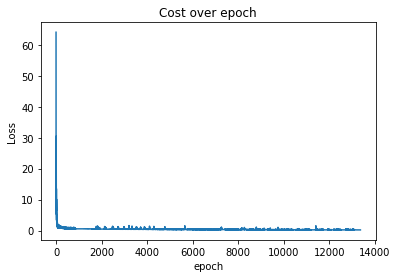

In [20]:
#graph cost
plt.plot(cost)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Cost over epoch")
plt.show()

In [21]:
#### predict X_test data
predictions=[]
with torch.no_grad():
    for i, data in enumerate(X_test):
        y_pred = model(data)
        predictions.append(y_pred.argmax().item())
        
predictions = np.array(predictions, dtype=np.int8)

In [22]:
loan = np.where(predictions == 1)[0]
not_loan = np.where(predictions == 0)[0]
print(f"Prediction loans count: {len(loan)}")
print(f"Prediction not loans count: {len(not_loan)}")

Prediction loans count: 209
Prediction not loans count: 80


In [23]:
# need test data to predict accuracy score. on previous split of train/validation on train, accuracy = 62%
# score = accuracy_score(y_test, predictions)

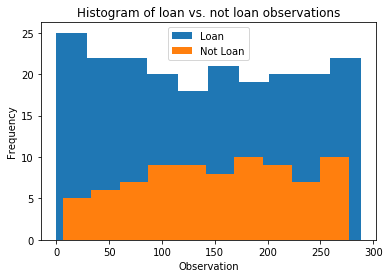

In [24]:
plt.hist(loan, label='Loan')
plt.hist(not_loan, label='Not Loan')
plt.legend()
plt.xlabel("Observation")
plt.ylabel("Frequency")
plt.title("Histogram of loan vs. not loan observations")
plt.show()

In [25]:
#Have no idea how to verify this. Author didn't publish test labels!!!

## Upload models

In [26]:
#Read more: https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save(model.state_dict(), "../models/loan_prediction.pth")